In [1]:
from qiskit.transpiler.passes.routing.sabre_swap_v020_lookahead import SabreSwap
from qiskit.transpiler.passes.layout.sabre_layout_v020 import SabreLayout
from ulti.circuits import get_circuit_list, sort_circuits_by_depth
from ulti.coupling_maps import file_to_coupling_map
from ulti.pass_managers import generate_pass_managers, transpiled_data
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import random
random.seed(42)
import os

# Runs the experiment for SabreSwap v0.20 lookahead


In [2]:
# Variables to change
qc_name = "ghz"

experiment_name = "sabre_look_0"
version = "20" # version for the routing pass after _v0.
lp_name = "sabre_0.20"
cp_name = "heavy_hex_127"

In [3]:
num_shots = 5
rp = SabreSwap
lp = SabreLayout
cm = file_to_coupling_map(f'coupling_maps/{cp_name}.txt')
pm = generate_pass_managers(num_shots, rp, lp, cm)


rp_name = experiment_name + "_v0." + version
qc_list = get_circuit_list([f'circuits/{qc_name}/'])
qc_list = sort_circuits_by_depth(qc_list)

csv_file_path = f'data/{qc_name}/{experiment_name}_v0{version}.csv'
directory = f'data/{qc_name}'
if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
data_list = []
for qc_idx, qc in enumerate(qc_list):
    data = transpiled_data(qc, pm)
    data['routing pass'] = rp_name
    data['layout pass'] = lp_name
    data['coupling map'] = cp_name
    data['circuit label'] = qc_idx
    data_list.append(data)

    print(f"Finished {qc_idx}")
print("Finished all")

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 55
Finished 56
Finished 57
Finished 58
Finished 59
Finished 60
Finished 61
Finished 62
Finished 63
Finished 64
Finished 65
Finished 66
Finished 67
Finished 68
Finished 69
Finished 70
Finished 71
Finished 72
Finished 73
Finished 74
Finished 75
Finished 76
Finished 77
Finished 78
Finished 79
Finished 80
Finished 81
Finished 82
Finished 83
Fi

In [5]:
df = pd.DataFrame(data_list)
df.to_csv(csv_file_path, index=False)
df

,best_data,std_dev,routing pass,layout pass,coupling map,circuit label
0,"{'depth': 2, 'depth_ratio': 1.0, 'time': 0.021...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00083...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,0
1,"{'depth': 3, 'depth_ratio': 1.0, 'time': 0.017...","{'depth': 1.2, 'depth_ratio': 0.4, 'time': 0.0...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,1
2,"{'depth': 6, 'depth_ratio': 1.5, 'time': 0.017...","{'depth': 2.638, 'depth_ratio': 0.6595, 'time'...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,2
3,"{'depth': 11, 'depth_ratio': 2.2, 'time': 0.01...","{'depth': 1.72, 'depth_ratio': 0.3441, 'time':...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,3
4,"{'depth': 14, 'depth_ratio': 2.33, 'time': 0.0...","{'depth': 1.497, 'depth_ratio': 0.2502, 'time'...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,4
...,...,...,...,...,...,...
121,"{'depth': 940, 'depth_ratio': 7.64, 'time': 0....","{'depth': 37.53, 'depth_ratio': 0.3056, 'time'...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,121
122,"{'depth': 964, 'depth_ratio': 7.77, 'time': 0....","{'depth': 75.24, 'depth_ratio': 0.6057, 'time'...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,122
123,"{'depth': 943, 'depth_ratio': 7.54, 'time': 0....","{'depth': 84.38, 'depth_ratio': 0.6753, 'time'...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,123
124,"{'depth': 931, 'depth_ratio': 7.39, 'time': 0....","{'depth': 57.3, 'depth_ratio': 0.4532, 'time':...",sabre_look_0_v0.20,sabre_0.20,heavy_hex_127,124


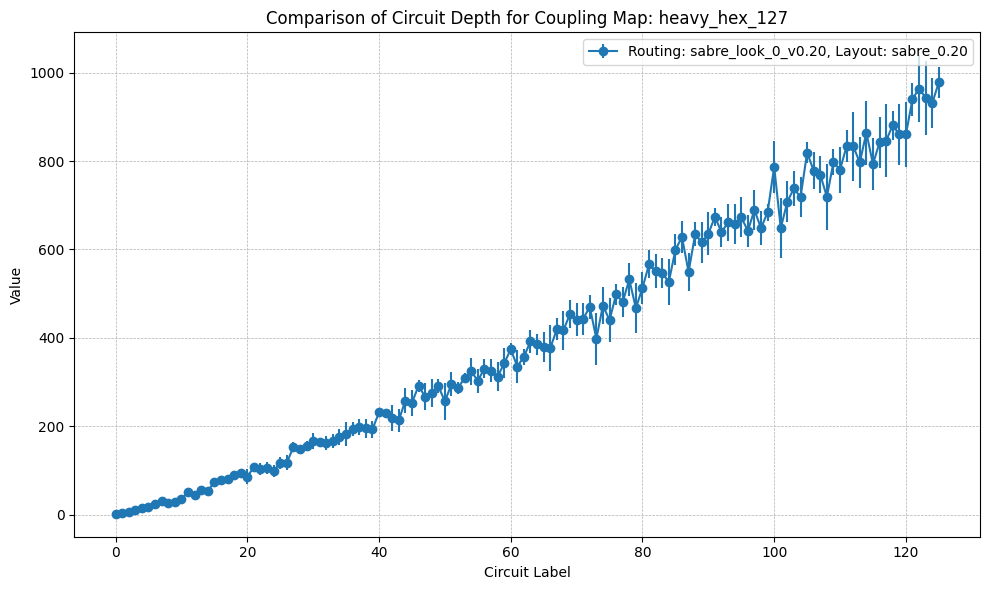

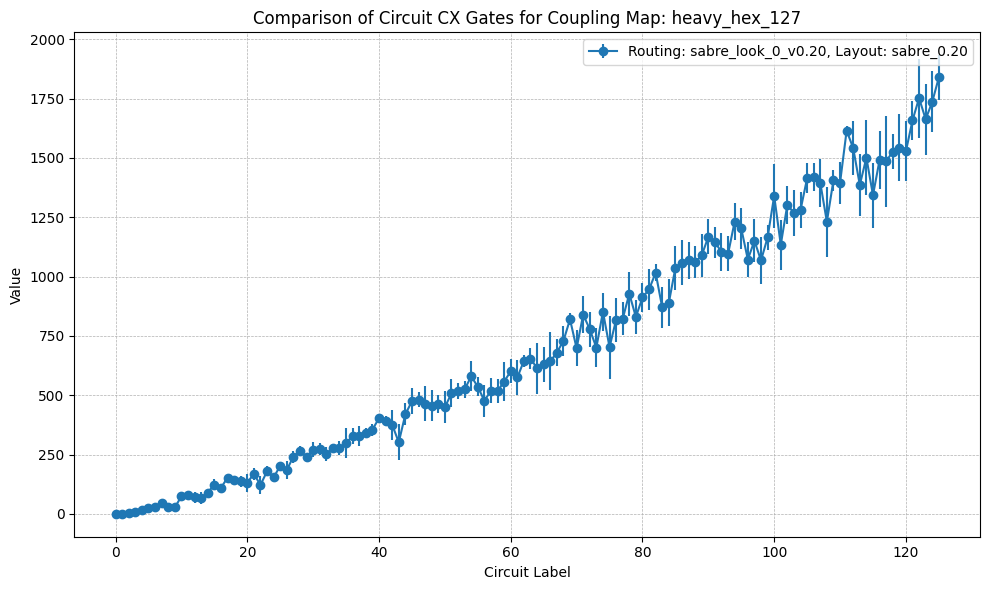

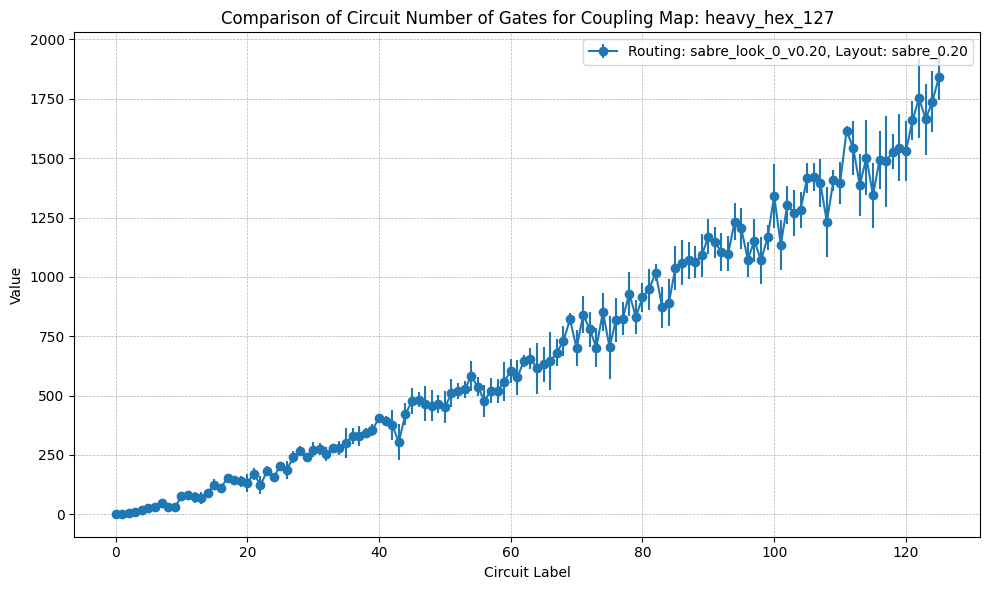

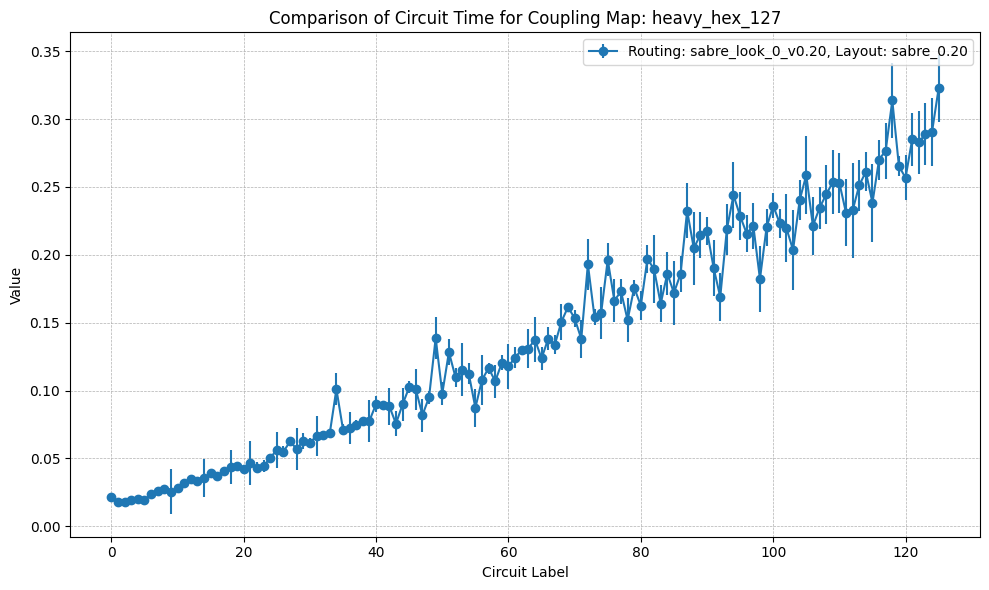

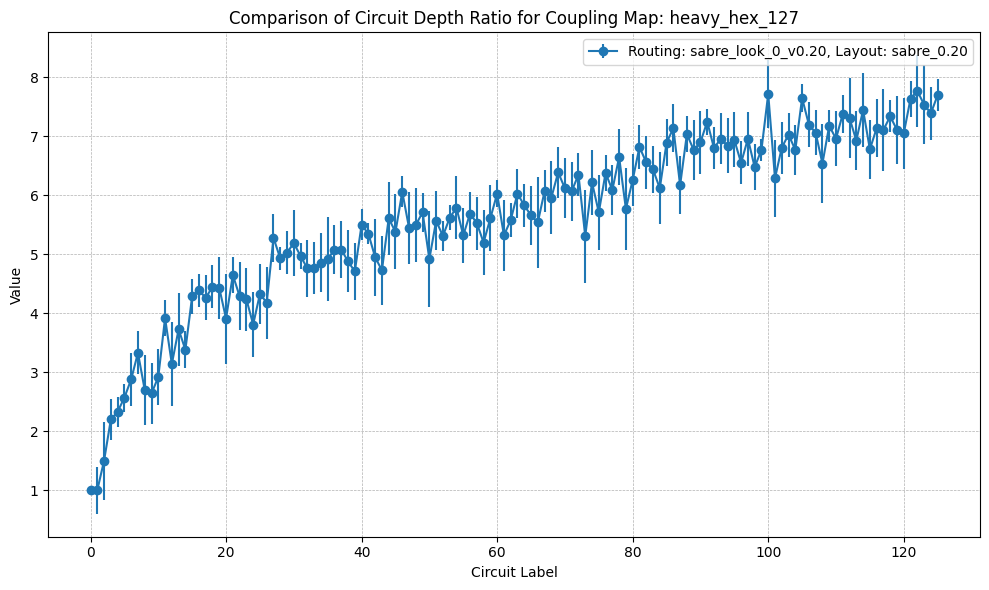

In [6]:
data = pd.read_csv(csv_file_path)

# Convert the string representation of dictionaries into actual dictionaries
data['best_data'] = data['best_data'].apply(literal_eval)
data['std_dev'] = data['std_dev'].apply(literal_eval)

# Extract the data from the 'best_data' and 'std_dev' columns and add them to the DataFrame
for col in ['depth', 'depth_ratio', 'time', 'cx_gates', 'num_gates']:
    data[f"best_{col}"] = data['best_data'].apply(lambda x: x[col])
    data[f"std_dev_{col}"] = data['std_dev'].apply(lambda x: x[col])

metrics = [
    ("depth", "Depth"),
    ("cx_gates", "CX Gates"),
    ("num_gates", "Number of Gates"),
    ("time", "Time"),
    ("depth_ratio", "Depth Ratio")
]

unique_routing_layout_combinations = data[['routing pass', 'layout pass']].drop_duplicates().values

for metric, label in metrics:
    plt.figure(figsize=(10, 6))
    for routing_pass, layout_pass in unique_routing_layout_combinations:
        subset = data[(data['routing pass'] == routing_pass) & (data['layout pass'] == layout_pass)]
        plt.errorbar(subset['circuit label'], subset[f"best_{metric}"], yerr=subset[f"std_dev_{metric}"], fmt='o-', label=f'Routing: {routing_pass}, Layout: {layout_pass}')
    plt.xlabel('Circuit Label')
    plt.ylabel('Value')
    plt.title(f'Comparison of Circuit {label} for Coupling Map: {data["coupling map"].iloc[0]}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    #plt.savefig(f"data/graphs/{qc_name}/{experiment_name}_v0{version}/{label.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()